In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## File Path Constant

In [2]:
file_path = {
    "filled_data": "../Data/filled_data.csv"
}

## Read Data as DataFrame

In [3]:
df_filled = pd.read_csv(file_path["filled_data"])

## Cor Matrix

In [4]:
feature_cols = df_filled.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in feature_cols if col not in ['Year']]

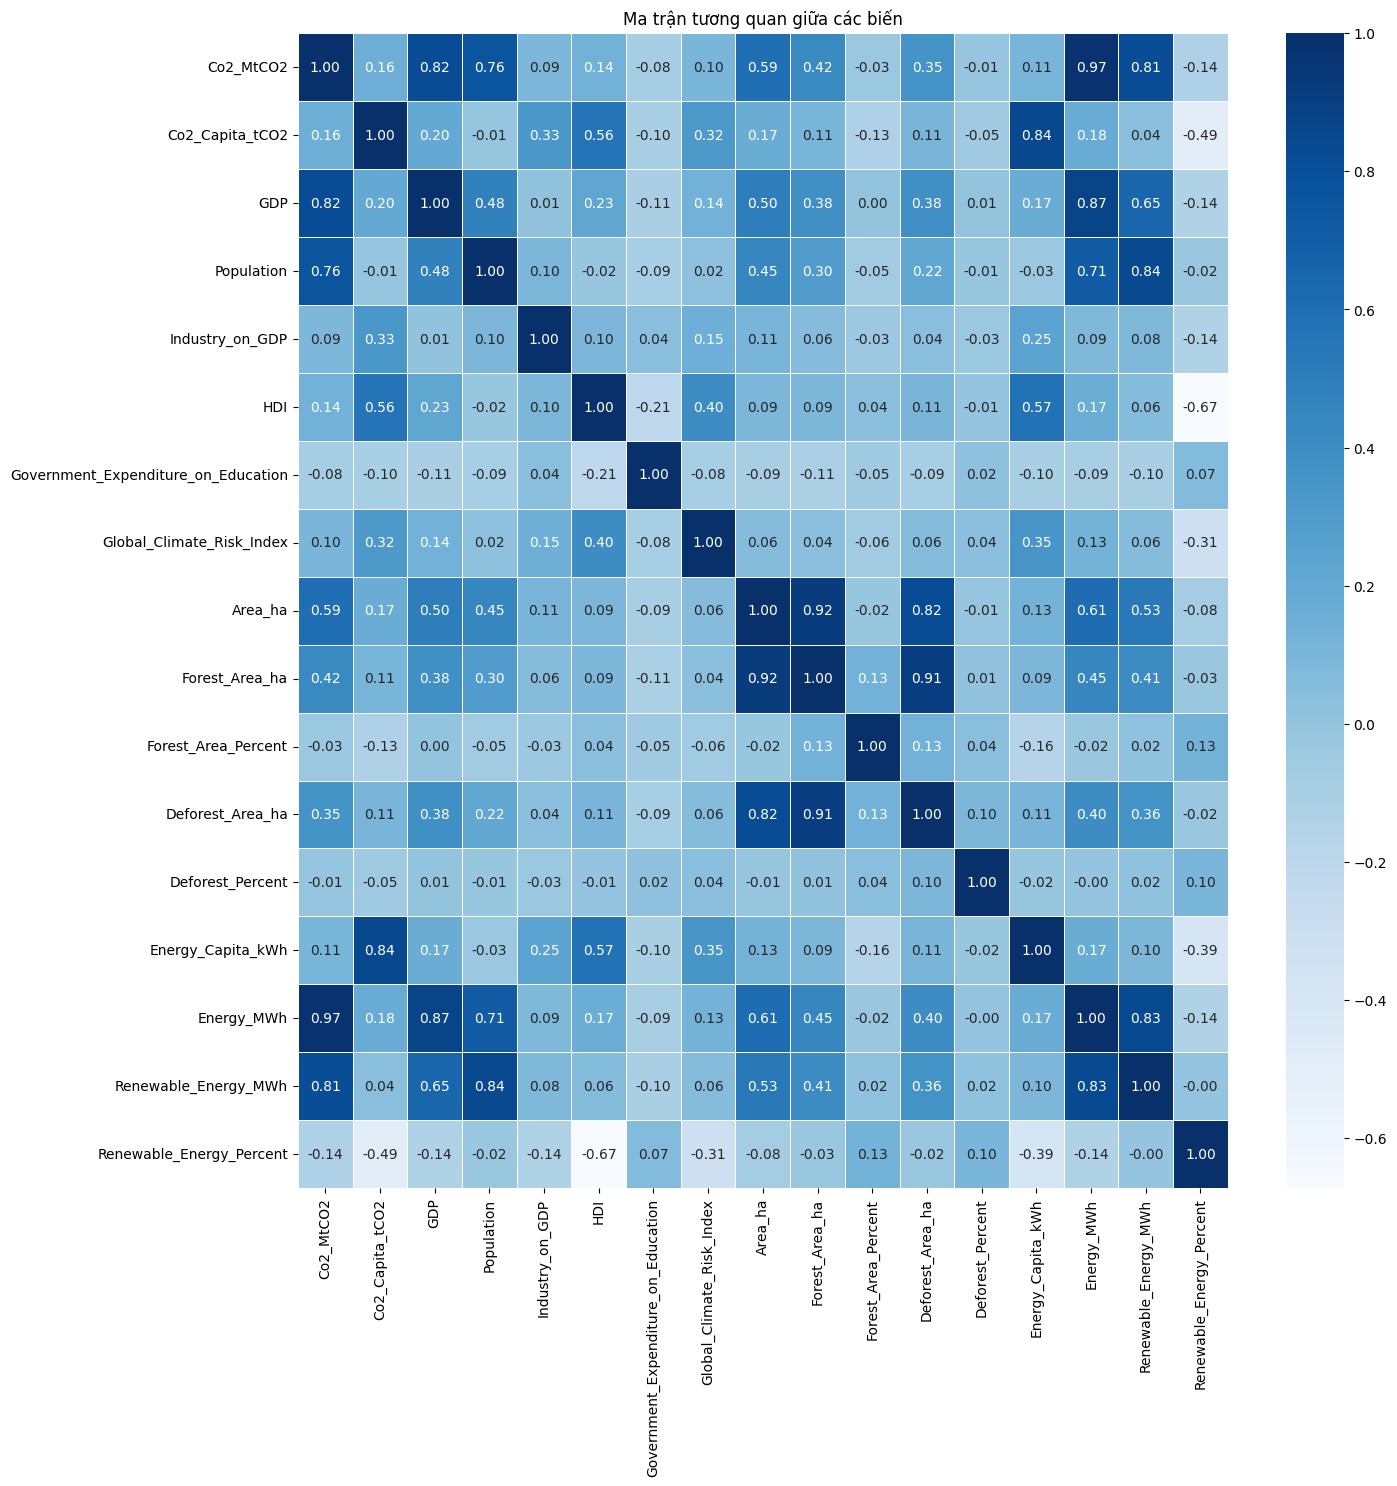

In [5]:
corr = df_filled[feature_cols].corr()
plt.figure(figsize=(15,15))
sns.heatmap(
    corr,
    annot=True,        # hiển thị giá trị hệ số
    fmt=".2f",         # 2 chữ số thập phân
    cmap="Blues",   # màu xanh
    linewidths=0.5
)
plt.title("Ma trận tương quan giữa các biến")
plt.show()

In [6]:
df_filled.columns

Index(['Country', 'ISO_Code', 'Year', 'Co2_MtCO2', 'Co2_Capita_tCO2', 'GDP',
       'Population', 'Industry_on_GDP', 'HDI',
       'Government_Expenditure_on_Education', 'Global_Climate_Risk_Index',
       'Area_ha', 'Forest_Area_ha', 'Forest_Area_Percent', 'Deforest_Area_ha',
       'Deforest_Percent', 'Energy_Capita_kWh', 'Energy_MWh',
       'Renewable_Energy_MWh', 'Renewable_Energy_Percent'],
      dtype='object')

In [7]:
features = [
    'Co2_MtCO2',
    'Population',
    'GDP',
    'Industry_on_GDP',
    'Government_Expenditure_on_Education',
    'Global_Climate_Risk_Index',
    'HDI',
    'Renewable_Energy_Percent',
    'Deforest_Percent',
    'Energy_Capita_kWh'
]

In [8]:
df_training = df_filled[['Country', 'Year'] + features].copy()

# Mã hóa quốc gia dạng số nguyên
le = LabelEncoder()
df_training['Country_Code'] = le.fit_transform(df_training['Country'])
num_countries = df_training['Country_Code'].nunique()

# Chuẩn hóa các feature numeric
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_training[features])

df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled['Country_Code'] = df_training['Country_Code'].values
df_scaled['Year'] = df_training['Year'].values

In [9]:
def split_train_test_by_year(df, features, target_col, time_steps=5, cutoff_year=2016):
    X_seq_train, X_seq_test = [], []
    X_country_train, X_country_test = [], []
    y_train, y_test = [], []

    for c in df['Country_Code'].unique():
        df_c = df[df['Country_Code'] == c].sort_values('Year')
        data_c = df_c[features + ['Year']].values
        target_idx = df_c.columns.get_loc(target_col)

        if len(data_c) <= time_steps + 1:
            continue

        for i in range(len(data_c) - time_steps):
            seq_x = data_c[i:i+time_steps, :-1]  # bỏ cột year
            seq_y = data_c[i+time_steps, target_idx]
            seq_year = data_c[i+time_steps, -1]

            if seq_year <= cutoff_year:
                X_seq_train.append(seq_x)
                y_train.append(seq_y)
                X_country_train.append(c)
            else:
                X_seq_test.append(seq_x)
                y_test.append(seq_y)
                X_country_test.append(c)

    X_seq_train = np.array(X_seq_train)
    X_seq_test = np.array(X_seq_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    X_country_train = np.array(X_country_train)
    X_country_test = np.array(X_country_test)

    print(f"Train samples: {len(X_seq_train)}, Test samples: {len(X_seq_test)}")
    print(f"Countries in train: {len(np.unique(X_country_train))}, in test: {len(np.unique(X_country_test))}")

    return X_seq_train, X_seq_test, X_country_train, X_country_test, y_train, y_test

## Dự đoán dựa vào dữ liệu 5 năm trước

In [10]:
target_col = 'Co2_MtCO2'
time_steps = 5
cutoff_year = 2018  # bạn có thể đổi sang 2018 tùy dữ liệu

X_seq_train, X_seq_test, X_country_train, X_country_test, y_train, y_test = \
    split_train_test_by_year(df_scaled, features, target_col, time_steps, cutoff_year=cutoff_year)

Train samples: 2470, Test samples: 760
Countries in train: 190, in test: 190


In [ ]:
embedding_dim = min(50, round(num_countries ** 0.25))
print(f"Embedding dimension: {embedding_dim}")

# Input 1: chuỗi thời gian
input_seq = Input(shape=(time_steps, 10), name="sequence_input")

# Input 2: mã quốc gia
input_country = Input(shape=(1,), name="country_input")
country_emb = Embedding(input_dim=num_countries, output_dim=embedding_dim, name="country_embedding")(input_country)
country_emb = Flatten()(country_emb)

# Nhánh LSTM xử lý chuỗi thời gian
gru_out = GRU(64, return_sequences=True)(input_seq)
gru_out = Dropout(0.2)(gru_out)
gru_out = GRU(32)(gru_out)

# Kết hợp 2 nhánh
concat = Concatenate()([gru_out, country_emb])
dense = Dense(32, activation='relu')(concat)
output = Dense(1)(dense)

model1 = Model(inputs=[input_seq, input_country], outputs=output)
model1.compile(optimizer='adam', loss='mse')

model1.summary()

# =============================
# Huấn luyện
# =============================

es = es = EarlyStopping(
    monitor='val_loss',       # theo dõi lỗi validation
    patience=10,              # dừng nếu sau 10 epoch không cải thiện
    restore_best_weights=True,# khôi phục mô hình tốt nhất
    min_delta=1e-4,           # cải thiện tối thiểu để tính là "tốt hơn"
    mode='min',               # vì loss cần giảm
    verbose=1
)
checkpoint_cb = ModelCheckpoint(
    filepath='./best_model_gru5.h5',          # Tên file lưu
    monitor='val_loss',                # Theo dõi metric (thường là val_loss)
    save_best_only=True,               # Chỉ lưu khi tốt hơn trước
    mode='min',                        # Nếu metric cần giảm (min = tốt)
    verbose=1                          # Hiển thị thông báo khi lưu
)

history = model1.fit(
    [X_seq_train, X_country_train],
    y_train,
    validation_data=([X_seq_test, X_country_test], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint_cb,es],
    verbose=1
)

Embedding dimension: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 5, 64)     │     14,592 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 64)     │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_embedding   │ (None, 1, 4)      │        760 │ country_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 32)        │      9,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4)         │          0 │ country_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36)        │          0 │ gru_1[0][0],      │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,977 (101.47 KB)

 Trainable params: 25,977 (101.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 1: val_loss improved from None to 0.00047, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 4.7287e-04
Epoch 2/20
55/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3419e-04
Epoch 2: val_loss improved from 0.00047 to 0.00029, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9422e-04 - val_loss: 2.8765e-04
Epoch 3/20
70/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9943e-04
Epoch 3: val_loss improved from 0.00029 to 0.00010, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8577e-04 - val_loss: 9.8209e-05
Epoch 4/20
56/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2794e-04
Epoch 4: val_loss improved from 0.00010 to 0.00007, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2742e-04 - val_loss: 7.0903e-05
Epoch 5/20
54/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1539e-04
Epoch 5: val_loss improved from 0.00007 to 0.00006, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0697e-04 - val_loss: 6.0414e-05
Epoch 6/20
58/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4437e-05
Epoch 6: val_loss improved from 0.00006 to 0.00003, saving model to ./best_model_gru5.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4261e-05 - val_loss: 2.5878e-05
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1659e-04
Epoch 7: val_loss did not improve from 0.00003
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1560e-04 - val_loss: 6.9847e-05
Epoch 8/20
54/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9645e-05
Epoch 8: val_loss did not improve from 0.00003
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7084e-05 - val_loss: 3.1824e-05
Epoch 9/20
59/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0334e-04
Epoch 9: val_loss did not improve from 0.00003
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3421e-05 - val_loss: 8.7838e-05
Epoch 10/20
73/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7383e-05
Epoch 10: val_loss did not improve from 0.00003
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5647e-05 - val_loss: 7.9460e-05
Epoch 11/20
52/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9961e-05
Epoch 11: val_loss did not improve from 0.00003
78/78 ━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 RMSE: 0.0099, MAE: 0.0064,R2: 0.9845


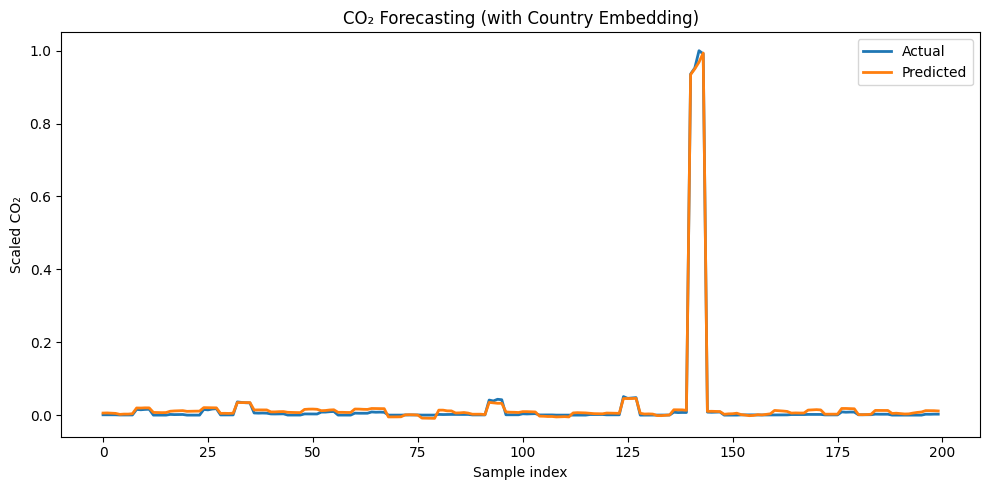

In [12]:
y_pred = model1.predict([X_seq_test, X_country_test])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n RMSE: {rmse:.4f}, MAE: {mae:.4f},R2: {r2:.4f}")

# =============================
# Biểu đồ so sánh thực tế - dự báo
# =============================

plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("CO₂ Forecasting (with Country Embedding)")
plt.xlabel("Sample index")
plt.ylabel("Scaled CO₂")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#Rescaled data
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), len(features)-1))], axis=1)
)[:, 0]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1))], axis=1)
)[:, 0]

real_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
real_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"RMSE thực tế: {real_rmse:.2f}, MAE thực tế: {real_mae:.2f}")

RMSE thực tế: 113.45, MAE thực tế: 73.72


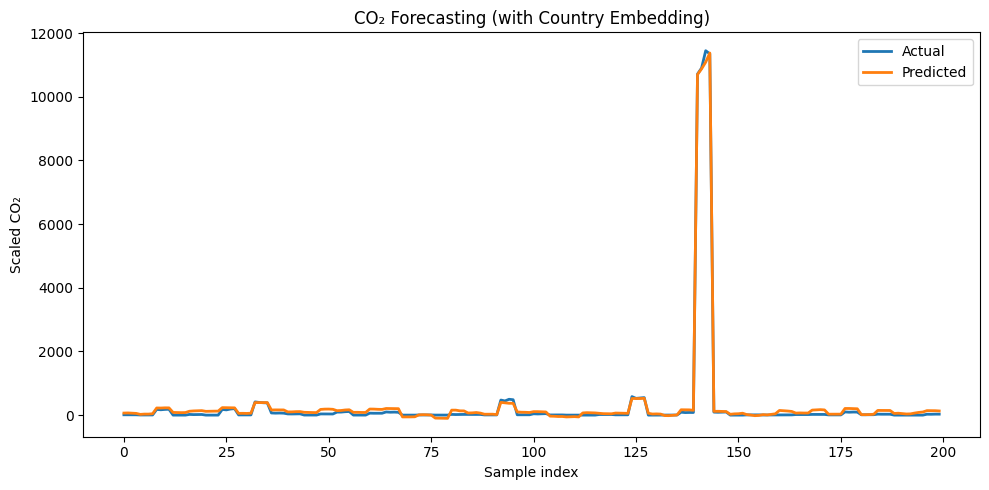

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:200], label='Actual', linewidth=2)
plt.plot(y_pred_rescaled[:200], label='Predicted', linewidth=2)
plt.title("CO₂ Forecasting (with Country Embedding)")
plt.xlabel("Sample index")
plt.ylabel("Scaled CO₂")
plt.legend()
plt.tight_layout()
plt.show()

## Dự đoán dựa vào dữ liệu 3 năm trước

In [15]:
X_seq_train_3, X_seq_test_3, X_country_train_3, X_country_test_3, y_train_3, y_test_3 = \
    split_train_test_by_year(df_scaled, features, target_col, 3, cutoff_year=2018)

Train samples: 2850, Test samples: 760
Countries in train: 190, in test: 190


In [16]:
input_seq_3 = Input(shape=(3, 10), name="sequence_input_3")  # 3 bước thời gian, 5 feature

# =============================
# Đầu vào 2: Mã quốc gia (dạng số nguyên)
# =============================
input_country = Input(shape=(1,), name="country_input_3")

num_countries = len(np.unique(X_country_train_3)) + 1  # +1 để tránh lỗi index
embedding_dim = 8

country_emb = Embedding(input_dim=num_countries, output_dim=embedding_dim, name="country_embedding")(input_country)
country_emb = Flatten()(country_emb)

# =============================
# Nhánh LSTM xử lý chuỗi thời gian
# =============================
gru_out = GRU(64, return_sequences=True)(input_seq_3)
gru_out = Dropout(0.2)(gru_out)
gru_out = GRU(32)(gru_out)

# =============================
# Kết hợp 2 nhánh
# =============================
concat = Concatenate()([gru_out, country_emb])
dense = Dense(32, activation='relu')(concat)
output = Dense(1)(dense)

# =============================
# Xây dựng & biên dịch mô hình
# =============================
model2 = Model(inputs=[input_seq_3, input_country], outputs=output)
model2.compile(optimizer='adam', loss='mse')

model2.summary()

# =============================
# Huấn luyện
# =============================

es = es = EarlyStopping(
    monitor='val_loss',       # theo dõi lỗi validation
    patience=10,              # dừng nếu sau 10 epoch không cải thiện
    restore_best_weights=True,# khôi phục mô hình tốt nhất
    min_delta=1e-4,           # cải thiện tối thiểu để tính là "tốt hơn"
    mode='min',               # vì loss cần giảm
    verbose=1
)
checkpoint_cb = ModelCheckpoint(
    filepath='./best_model_gru3.h5',          # Tên file lưu
    monitor='val_loss',                # Theo dõi metric (thường là val_loss)
    save_best_only=True,               # Chỉ lưu khi tốt hơn trước
    mode='min',                        # Nếu metric cần giảm (min = tốt)
    verbose=1                          # Hiển thị thông báo khi lưu
)
history = model2.fit(
    [X_seq_train_3, X_country_train_3],
    y_train_3,
    validation_data=([X_seq_test_3, X_country_test_3], y_test_3),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint_cb,es],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input_3    │ (None, 3, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 3, 64)     │     14,592 │ sequence_input_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_input_3     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3, 64)     │          0 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_embedding   │ (None, 1, 8)      │      1,528 │ country_input_3[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 32)        │      9,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ country_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ gru_3[0][0],      │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,312 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,873 (104.97 KB)

 Trainable params: 26,873 (104.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 1: val_loss improved from None to 0.00020, saving model to ./best_model_gru3.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - val_loss: 2.0059e-04
Epoch 2/20
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9882e-04
Epoch 2: val_loss improved from 0.00020 to 0.00010, saving model to ./best_model_gru3.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7487e-04 - val_loss: 9.6846e-05
Epoch 3/20
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1077e-04
Epoch 3: val_loss did not improve from 0.00010
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3022e-04 - val_loss: 1.7372e-04
Epoch 4/20
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4558e-05
Epoch 4: val_loss improved from 0.00010 to 0.00004, saving model to ./best_model_gru3.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0964e-04 - val_loss: 3.7900e-05
Epoch 5/20
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3017e-05
Epoch 5: val_loss did not improve from 0.00004
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2599e-05 - val_loss: 1.6744e-04
Epoch 6/20
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1325e-04
Epoch 6: val_loss did not improve from 0.00004
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9237e-05 - val_loss: 6.9177e-05
Epoch 7/20
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0456e-05
Epoch 7: val_loss did not improve from 0.00004
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0486e-05 - val_loss: 5.6610e-05
Epoch 8/20
85/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0057e-04
Epoch 8: val_loss did not improve from 0.00004
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8539e-05 - val_loss: 5.2459e-05
Epoch 9/20
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2506e-05
Epoch 9: val_loss did not improve from 0.00004
90/90 ━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

 RMSE: 0.0098, MAE: 0.0045,R2: 0.9847


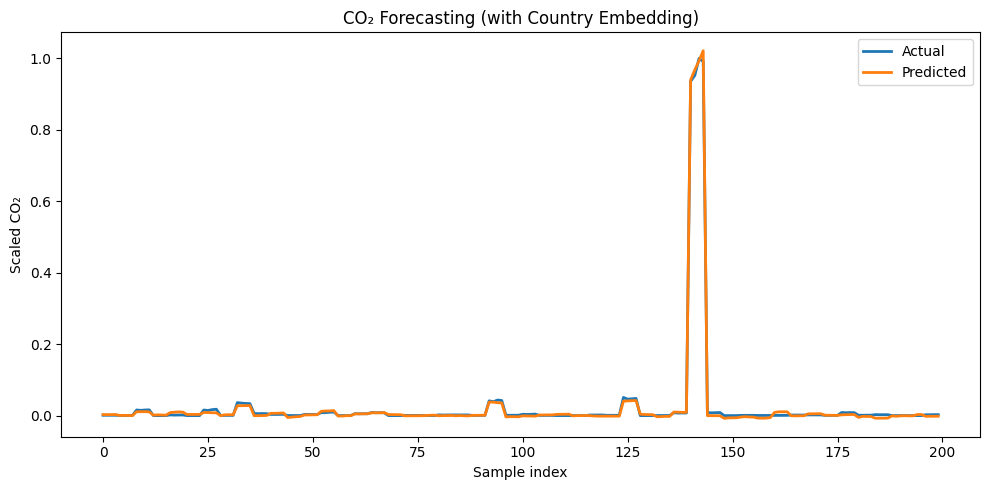

In [17]:
y_pred_3 = model2.predict([X_seq_test_3, X_country_test_3])

rmse_3 = np.sqrt(mean_squared_error(y_test_3, y_pred_3))
mae_3 = mean_absolute_error(y_test_3, y_pred_3)
r2_3 = r2_score(y_test_3, y_pred_3)
print(f"\n RMSE: {rmse_3:.4f}, MAE: {mae_3:.4f},R2: {r2_3:.4f}")

# =============================
# Biểu đồ so sánh thực tế - dự báo
# =============================

plt.figure(figsize=(10, 5))
plt.plot(y_test_3[:200], label='Actual', linewidth=2)
plt.plot(y_pred_3[:200], label='Predicted', linewidth=2)
plt.title("CO₂ Forecasting (with Country Embedding)")
plt.xlabel("Sample index")
plt.ylabel("Scaled CO₂")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
#Rescaled data
y_pred_rescaled_3 = scaler.inverse_transform(
    np.concatenate([y_pred_3, np.zeros((len(y_pred_3), len(features)-1))], axis=1)
)[:, 0]

y_test_rescaled_3 = scaler.inverse_transform(
    np.concatenate([y_test_3.reshape(-1,1), np.zeros((len(y_test_3), len(features)-1))], axis=1)
)[:, 0]

real_rmse_3 = np.sqrt(mean_squared_error(y_test_rescaled_3, y_pred_rescaled_3))
real_mae_3 = mean_absolute_error(y_test_rescaled_3, y_pred_rescaled_3)

print(f"RMSE thực tế: {real_rmse_3:.2f}, MAE thực tế: {real_mae_3:.2f}")

RMSE thực tế: 112.66, MAE thực tế: 51.02


In [19]:
def predict_yearly_co2(country_name, last_num_years, predict_year, model, le=le, scaler=scaler, features=features, time_steps=5):
    # --- Kiểm tra đầu vào ---
    if len(last_num_years) != time_steps:
        raise ValueError(f"Cần đúng {time_steps} năm dữ liệu, nhưng bạn truyền {len(last_num_years)}")

    # --- Chuẩn hóa dữ liệu ---
    input_scaled = scaler.transform(last_num_years)
    X_new = np.expand_dims(input_scaled, axis=0)  # (1, time_steps, num_features)

    # --- Mã hóa quốc gia ---
    if country_name not in le.classes_:
        raise ValueError(f"'{country_name}' không có trong danh sách quốc gia đã huấn luyện.")
    country_code = le.transform([country_name])[0]
    X_country = np.array([[country_code]], dtype='int32')  # (1, 1)

    if time_steps == 5:
        model = model1
    elif time_steps == 3:
        model = model2
    else:
        raise ValueError(f"Chỉ hỗ trợ model với 3 hoặc 5 năm, bạn nhập {time_steps}.")

    if model is None:
        raise ValueError(f"Model tương ứng ({time_steps} năm) chưa được cung cấp!")
    # --- Dự đoán ---
    y_pred_scaled = model.predict([X_new, X_country], verbose=0)

    # --- Đảo chuẩn hóa về giá trị thực ---
    y_pred_real = scaler.inverse_transform(
        np.concatenate([y_pred_scaled, np.zeros((1, len(features)-1))], axis=1)
    )[0, 0]

    print(f"\nDự báo CO₂ của {country_name} năm {predict_year}: {y_pred_real:.2f} MtCO₂")
    return y_pred_real

## Forecast VietNam 2021

In [20]:
df_vietnam = df_filled.loc[df_filled['Country']=='Viet Nam',
    ['Co2_MtCO2','Population',
    'GDP',
    'Industry_on_GDP',
    'Government_Expenditure_on_Education',
    'Global_Climate_Risk_Index',
    'HDI',
    'Renewable_Energy_Percent',
    'Deforest_Percent',
    'Energy_Capita_kWh',
    'Year']].sort_values('Year')

In [21]:
last_5_years_VN=df_vietnam.loc[(df_vietnam['Year'] >= 2016) & (df_vietnam['Year'] <= 2020)].drop(columns=['Year']).to_numpy().tolist()

In [22]:
last_3_years_VN=df_vietnam.loc[(df_vietnam['Year'] >= 2018) & (df_vietnam['Year'] <= 2020)].drop(columns=['Year']).to_numpy().tolist()

In [23]:
predict_yearly_co2(
    country_name="Viet Nam",
    last_num_years=last_5_years_VN,
    predict_year=2021,
    model=model1,
    le=le,
    scaler=scaler,
    features=features,
    time_steps=5
)
print(f"Dữ liệu CO2 của Viet Nam năm 2021: {df_vietnam.loc[df_vietnam["Year"] == 2021, "Co2_MtCO2"].iloc[0]} MtCO2")


Dự báo CO₂ của Viet Nam năm 2021: 298.57 MtCO₂
Dữ liệu CO2 của Viet Nam năm 2021: 313.973 MtCO2


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [24]:
predict_yearly_co2(
    country_name="Viet Nam",
    last_num_years=last_3_years_VN,
    predict_year=2021,
    model=model2,
    le=le,
    scaler=scaler,
    features=features,
    time_steps=3
)
print(f"Dữ liệu CO2 của Viet Nam năm 2021: {df_vietnam.loc[df_vietnam["Year"] == 2021, "Co2_MtCO2"].iloc[0]} MtCO2")

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



Dự báo CO₂ của Viet Nam năm 2021: 165.83 MtCO₂
Dữ liệu CO2 của Viet Nam năm 2021: 313.973 MtCO2


## Forecast China 2021

In [25]:
df_china = df_filled.loc[df_filled['Country']=='China', ['Co2_MtCO2','Population',
    'GDP',
    'Industry_on_GDP',
    'Government_Expenditure_on_Education',
    'Global_Climate_Risk_Index',
    'HDI',
    'Renewable_Energy_Percent',
    'Deforest_Percent',
    'Energy_Capita_kWh',
    'Year']].sort_values('Year')

In [26]:
last_5_years_TQ=df_china.loc[(df_china['Year'] >= 2016) & (df_china['Year'] <= 2020)].drop(columns=['Year']).to_numpy().tolist()
last_3_years_TQ=df_china.loc[(df_china['Year'] >= 2018) & (df_china['Year'] <= 2020)].drop(columns=['Year']).to_numpy().tolist()

In [27]:
predict_yearly_co2(
    country_name="China",
    last_num_years=last_5_years_TQ,
    predict_year=2021,
    model=model1,
    le=le,
    scaler=scaler,
    features=features,
    time_steps=5
)
print(f"Dữ liệu CO2 của Viet Nam năm 2021: {df_china.loc[df_china["Year"] == 2021, "Co2_MtCO2"].iloc[0]} MtCO2")

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



Dự báo CO₂ của China năm 2021: 11088.71 MtCO₂
Dữ liệu CO2 của Viet Nam năm 2021: 11447.913 MtCO2


In [28]:
predict_yearly_co2(
    country_name="China",
    last_num_years=last_3_years_TQ,
    predict_year=2021,
    model=model2,
    le=le,
    scaler=scaler,
    features=features,
    time_steps=3
)
print(f"Dữ liệu CO2 của Viet Nam năm 2021: {df_china.loc[df_china["Year"] == 2021, "Co2_MtCO2"].iloc[0]} MtCO2")


Dự báo CO₂ của China năm 2021: 11373.18 MtCO₂
Dữ liệu CO2 của Viet Nam năm 2021: 11447.913 MtCO2


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
